In [279]:
import numpy as np
import h5py
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import os

import sklearn.preprocessing as prep
import tensorflow as tf

from LstmVAE import LSTM_Var_Autoencoder
from LstmVAE import preprocess

name = '/home/mabbasloo/Documents/carData4/data/lbo/'
name1 = '/home/mabbasloo/Desktop/Variational-Lstm-Autoencoder/data/'

In [281]:
filename = '/home/mabbasloo/Desktop/Variational-Lstm-Autoencoder/list'
st = 10
stride = 6
with open(filename) as f:
    data = f.readlines() 
data = [x.strip() for x in data]   
data = sorted(data, key=lambda x:x[0:4])[0::stride]
print (len(data), np.int(len(data)/st))
for i in range(2*st):
    print (data[i])
#print (data[len(data)-1])
#for i in range(len(data)):
#    print (data[i])

2050 205
f001_S2000001_1.mat
f001_S2000001_7.mat
f001_S2000001_13.mat
f001_S2000001_19.mat
f001_S2000001_25.mat
f001_S2000001_31.mat
f001_S2000001_37.mat
f001_S2000001_43.mat
f001_S2000001_49.mat
f001_S2000001_55.mat
f002_S2000001_1.mat
f002_S2000001_7.mat
f002_S2000001_13.mat
f002_S2000001_19.mat
f002_S2000001_25.mat
f002_S2000001_31.mat
f002_S2000001_37.mat
f002_S2000001_43.mat
f002_S2000001_49.mat
f002_S2000001_55.mat


In [283]:
DATA = []
d = 20
#hm = 20*st
hm = len(data)
dim1 = 1714
db = h5py.File(name + data[0], 'r')
ds = db['Phi']
ds = np.asarray(ds).astype(np.float32).T
ds = ds[:, 0:d]
ds[np.isnan(ds)] = 0.0
ds[np.isinf(ds)] = 0.0
for i in range(hm):
    #db = h5py.File(name + data[i], 'r')
    #ds = db['Phi']
    #ds = np.asarray(ds).astype(np.float32).T
    #ds = ds[:, 500-d:]
    #print (ds.shape)
    db1 = h5py.File(name1 + data[i], 'r')
    ds1 = db1['shape_xyz']
    ds1 = np.asarray(ds1).astype(np.float32)
    ds1[np.isnan(ds1)] = 0.0
    ds1[np.isinf(ds1)] = 0.0
    ds1[0] = ds1[0]/np.linalg.norm(ds1[0])
    ds1[1] = ds1[1]/np.linalg.norm(ds1[1])
    ds1[2] = ds1[2]/np.linalg.norm(ds1[2])    
    if ds1.shape[1] == dim1: # f256_S2000001_6.mat has different dimension so f256_S2000001* are removed.
        DATA.append(np.dot(ds1, ds))
    else:
        print (data[i])     

dim = np.int(len(data)/st)

print (len(DATA), DATA[0].shape, dim)

def standard_scale(X_train):
    for i in range(len(X_train)):
        X_train[i] = X_train[i]/np.linalg.norm(X_train[i], 'fro')
    return X_train

DATA = standard_scale(DATA)

2050 (3, 20) 205


Text(0.5, 0, 'z')

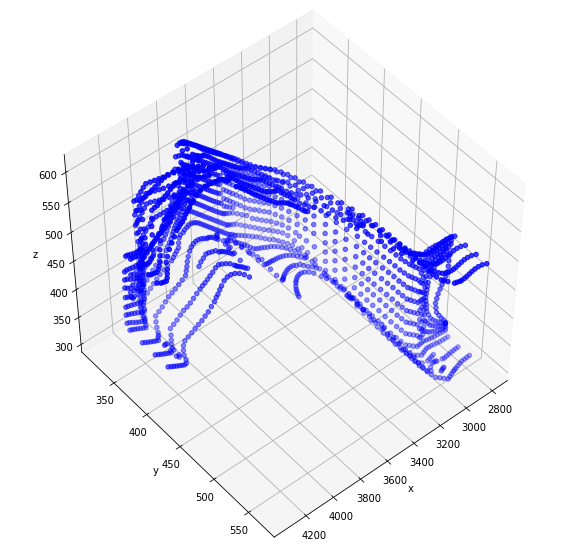

In [284]:
db1 = h5py.File(name1 + data[0], 'r')
ds1 = db1['shape_xyz']
ds1 = np.asarray(ds1).astype(np.float32)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(ds1[0], ds1[1], ds1[2], c='b', marker='o')
ax.view_init(50, 50)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

(3, 1714)


Text(0.5, 0, 'z')

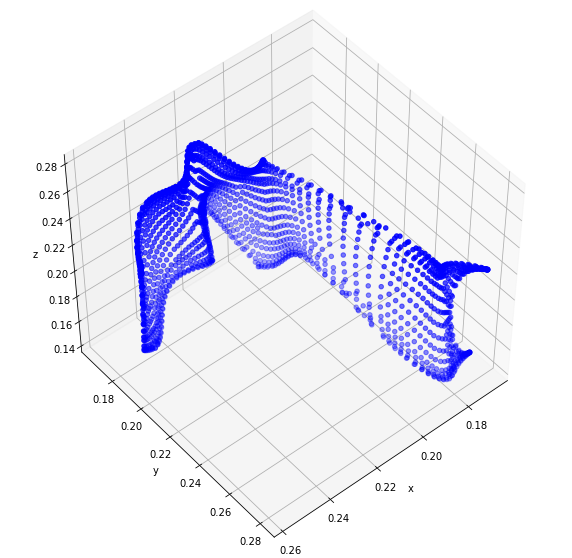

In [285]:
xyz = np.dot(DATA[0], np.linalg.pinv(ds))
print (xyz.shape)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xyz[0], xyz[1], xyz[2], c='b', marker='o')
ax.view_init(50, 50)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

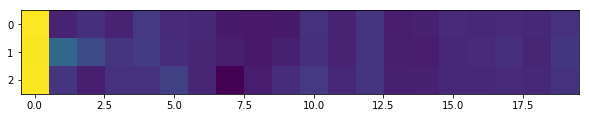

In [286]:
plt.figure(figsize=(10, 10)); 
plt.imshow(DATA[0])

In [287]:
dim2 = 100
vae = LSTM_Var_Autoencoder(intermediate_dim = 10, z_dim = 3, n_dim=d, stateful = False) #default stateful = False

vae.fit(DATA[0:dim2*st], learning_rate=0.001, batch_size = 10, num_epochs = 200, opt = tf.train.AdamOptimizer, REG_LAMBDA = 0.01, grad_clip_norm=10, optimizer_params=None, verbose = True)



Training...


Epoch   1    Loss 0.01588
Epoch   11   Loss 0.00008
Epoch   21   Loss 0.00001
Epoch   31   Loss 0.00001
Epoch   41   Loss 0.00001
Epoch   51   Loss 0.00001
Epoch   61   Loss 0.00001
Epoch   71   Loss 0.00001
Epoch   81   Loss 0.00001
Epoch   91   Loss 0.00001
Epoch  101   Loss 0.00001
Epoch  111   Loss 0.00001
Epoch  121   Loss 0.00001
Epoch  131   Loss 0.00001
Epoch  141   Loss 0.00001
Epoch  151   Loss 0.00001
Epoch  161   Loss 0.00001
Epoch  171   Loss 0.00001
Epoch  181   Loss 0.00001
Epoch  191   Loss 0.00001


Training time 2.87 minutes


In [288]:
x_reconstructed, recons_error = vae.reconstruct(DATA[dim2*st:], get_error = True) #returns squared error

x_reduced = vae.reduce(DATA) #latent space representation

Text(0.5, 0, 'latent 3')

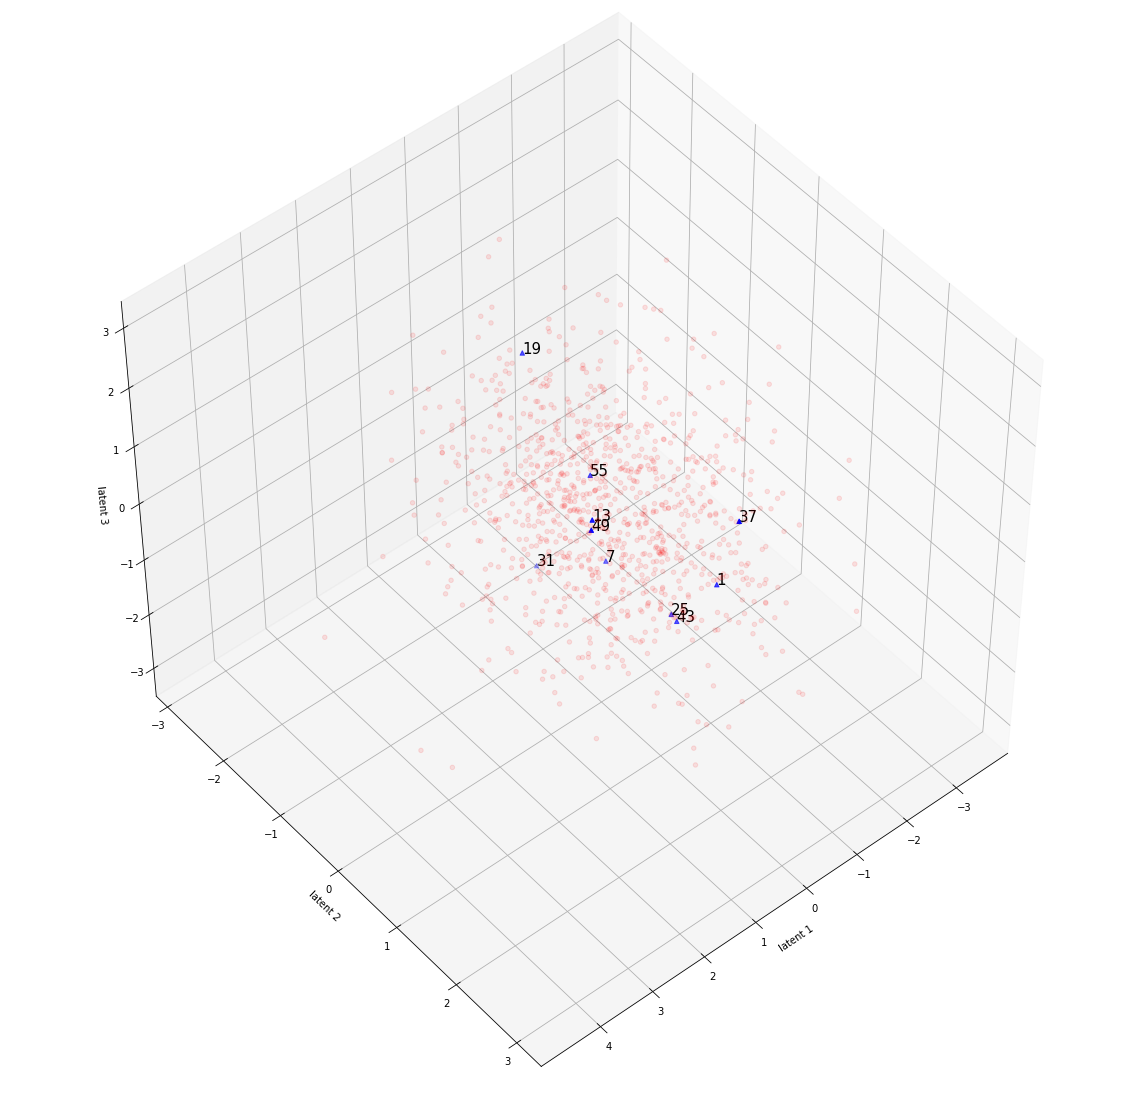

In [289]:
fig = plt.figure(figsize=(20, 20))
c = ['r', 'b']
m = ['o', '^']
label = []
for i in range(0, st):
    label.append(np.str(i*stride+1))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_reduced[0:dim2*st, 0], x_reduced[0:dim2*st, 1], x_reduced[0:dim2*st, 2], c=c[0], marker=m[0], alpha=0.1)
ax.scatter(x_reduced[dim2*st:(dim2+1)*st, 0], x_reduced[dim2*st:(dim2+1)*st, 1], x_reduced[dim2*st:(dim2+1)*st, 2], c=c[1], marker=m[1])
ii = 0
for i in range(dim2*st, (dim2+1)*st):
    ax.text(x_reduced[i, 0], x_reduced[i, 1], x_reduced[i, 2], label[ii], size=15, zorder=1, color='k') 
    ii += 1
ax.view_init(50, 50)
ax.set_xlabel('latent 1')
ax.set_ylabel('latent 2')
ax.set_zlabel('latent 3')

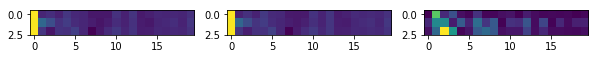

In [290]:
plt.figure(figsize=(10, 30)); 
plt.subplot(1,3,1); plt.imshow(x_reconstructed[0])
plt.subplot(1,3,2); plt.imshow(DATA[dim2*st])
plt.subplot(1,3,3); plt.imshow(np.abs(x_reconstructed[0] - DATA[dim2*st]))

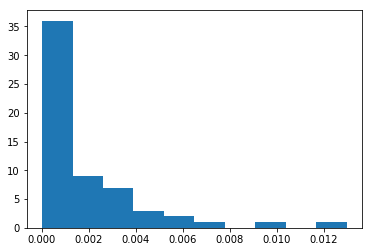

In [291]:
_,_,_ = plt.hist(np.abs(x_reconstructed[0] - DATA[dim2*st]).reshape((3*d)), bins=10)

(3, 1714)


Text(0.5, 0, 'z')

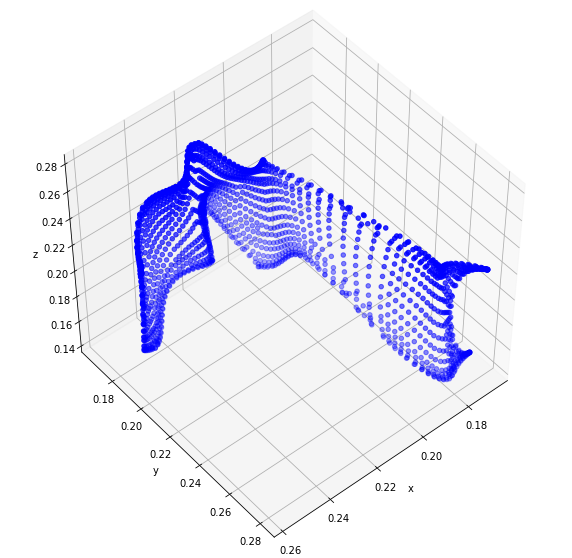

In [292]:
xyz = np.dot(DATA[dim2*st], np.linalg.pinv(ds))
print (xyz.shape)
fig = plt.figure(figsize=(10, 10))
c = ['b', 'r']
m = ['o', 'o']
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xyz[0], xyz[1], xyz[2], c=c[0], marker=m[0])
ax.view_init(50, 50)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

(3, 1714)


Text(0.5, 0, 'z')

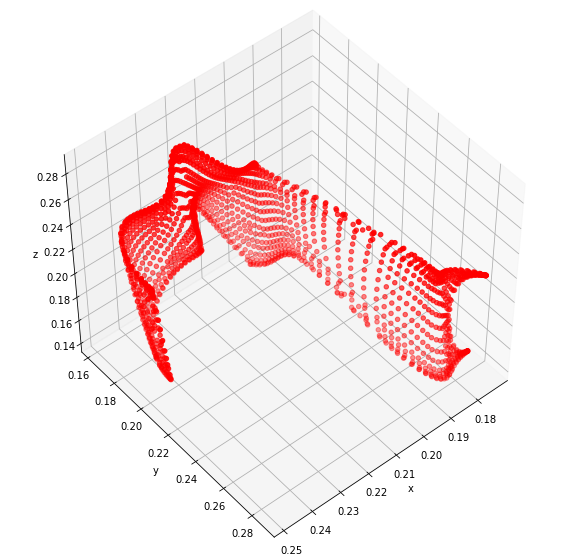

In [293]:
xyz_reconstructed = np.dot(x_reconstructed[0], np.linalg.pinv(ds))
print (xyz_reconstructed.shape)
fig = plt.figure(figsize=(10, 10))
c = ['b', 'r']
m = ['^', 'o']
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xyz_reconstructed[0], xyz_reconstructed[1], xyz_reconstructed[2], c=c[1], marker=m[1])
ax.view_init(50, 50)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

In [304]:
print (x_reduced.shape)
DATA2 = []
for i in range(dim):
    d = x_reduced[i*st:(i+1)*st].T
    d[0] = d[0]/np.linalg.norm(d[0])
    d[1] = d[1]/np.linalg.norm(d[1])
    d[2] = d[2]/np.linalg.norm(d[2])

    DATA2.append(d)
print (len(DATA2), DATA2[0].shape)  
dd = st
dim2 = 100

(2050, 3)
205 (3, 10)


In [310]:
vae2 = LSTM_Var_Autoencoder(intermediate_dim = 10, z_dim = 3, n_dim=dd, stateful = True) #default stateful = False

vae2.fit(DATA2[0:dim2], learning_rate=0.001, batch_size = 10, num_epochs = 100, opt = tf.train.AdamOptimizer, REG_LAMBDA = 0.01, grad_clip_norm=10, optimizer_params=None, verbose = True)



Training...


Epoch   1    Loss 0.11832
Epoch   11   Loss 0.10238
Epoch   21   Loss 0.10050
Epoch   31   Loss 0.09995
Epoch   41   Loss 0.09945
Epoch   51   Loss 0.09936
Epoch   61   Loss 0.09932
Epoch   71   Loss 0.09927
Epoch   81   Loss 0.09931
Epoch   91   Loss 0.09932


Training time 0.14 minutes


In [311]:
x_reconstructed2, recons_error2 = vae2.reconstruct(DATA2[dim2:], get_error = True) #returns squared error

x_reduced2 = vae2.reduce(DATA2) #latent space representation

Text(0.5, 0, 'latent 3')

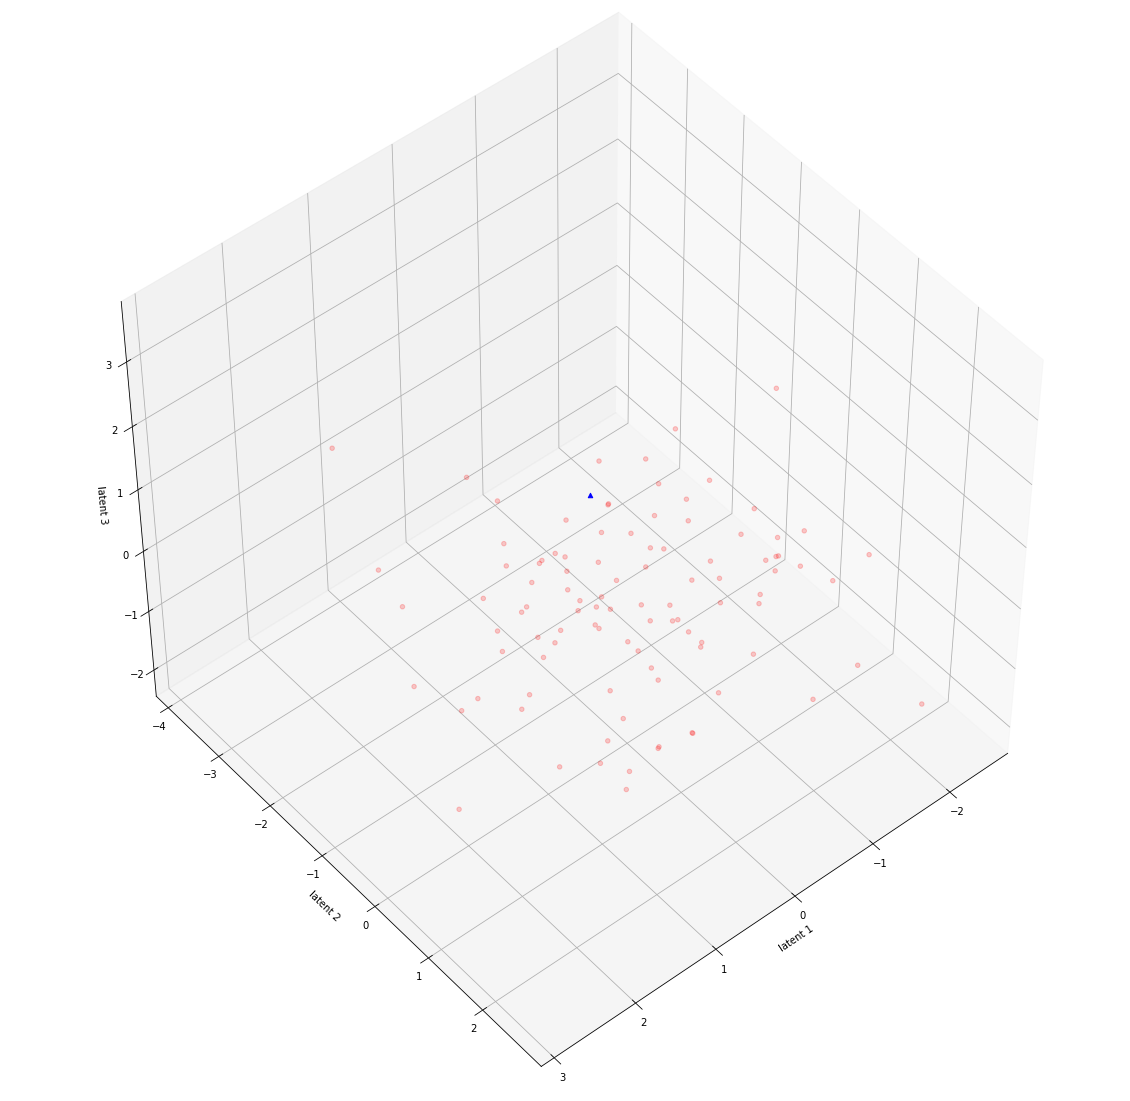

In [312]:
fig = plt.figure(figsize=(20, 20))
c = ['r', 'b']
m = ['o', '^']

ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_reduced2[0:dim2, 0], x_reduced2[0:dim2, 1], x_reduced2[0:dim2, 2], c=c[0], marker=m[0], alpha=0.2)
ax.scatter(x_reduced2[dim2:dim2+1, 0], x_reduced2[dim2:dim2+1, 1], x_reduced2[dim2:dim2+1, 2], c=c[1], marker=m[1])

ax.view_init(50, 50)
ax.set_xlabel('latent 1')
ax.set_ylabel('latent 2')
ax.set_zlabel('latent 3')

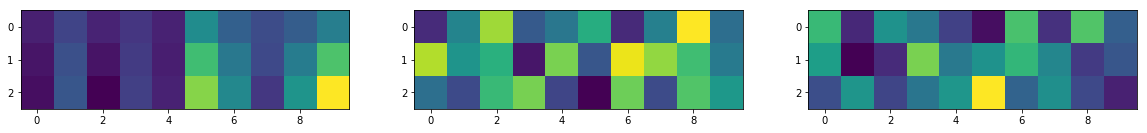

In [313]:
plt.figure(figsize=(20, 60)); 
plt.subplot(1,3,1); plt.imshow(x_reconstructed2[0])
plt.subplot(1,3,2); plt.imshow(DATA2[dim2])
plt.subplot(1,3,3); plt.imshow(np.abs(x_reconstructed2[0] - DATA2[dim2]))

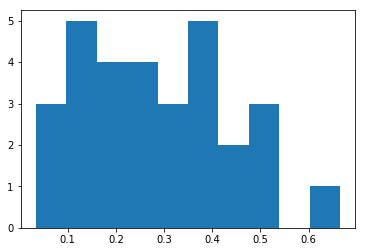

In [314]:
_,_,_ = plt.hist(np.abs(x_reconstructed2[0] - DATA2[dim2]).reshape((3*dd)), bins=10)